# Process 'Company Retention Next Role' Question Using a LLM

A generic version of the pipeline to be re-used for different types of questions.

Andrew Weng, 1/1/2025

We are going to use a mixed LLM-Python approach to solve the problem of "user text categorization."

This problem can be decomposed into five steps:

1. Pre-process (LLM1)
 - Each user provides up to three keywords as a string. These keywords need to be normalized and stored in a large list of individual keywords for the next stage.
2. Define categories (LLM2)
 - With the list of keywords, find the best set of categories to describe the keywords
3. Assign categories (LLM3)
 - For each keyword, assign it to a category. Be careful about how to handle exceptions (e.g., a keyword that doesn't seem to belog into any particular category.)
4. Count occurences (Python)
 - Within each category, sum up the total number of keywords. 
5. Visualize the results (Python)

In [1]:
import os
import time

current_folder = os.path.basename(os.getcwd())
if current_folder == 'notebooks':
    root_path = os.path.dirname(os.path.abspath(''))
    os.chdir(root_path)

from src.analyst import Analyst
from src.plotter import Plotter
from src.llm import LLM

from collections import defaultdict

import pickle
from pprint import pprint

from IPython import get_ipython
# Automatically reload all modules every time a line of code is executed
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

# Initialize our helper classes

In [2]:
analyst = Analyst()
analyst.load_data()
analyst.build_respondents_list()

plotter = Plotter()
llm = LLM()

# Fetch the relevant dataset to analyze

In [3]:
question = dict()
question['tag'] = 'company_retention_next_role_looking_for'
question['question'] = "Is there anything else you'd like to share about what you're looking for in your next role?"
question['categories'] = ['Location / Geography / Relocation / Remote Work Preferences',
 'Salary / Compensation / Money / Equity / Benefits',
 'Career Growth / Advancement / Professional Development',
 'Company Culture / Team Atmosphere / Work Environment',
 'Work-Life Balance / Flexible Work Arrangements',
 'Stability / Job Security / Company Viability',
 'Interesting Work / Impact / Environmental / Sustainability / Technology',
 'Role / Responsibilities / Leadership / Job Position',
 'Training / Learning / Mentorship Opportunities',
 'Diversity / Inclusion / Fair Treatment',
 'Company Vision / Mission / Values / Reputation',
 'Company Financial Stability / Funding / Viability',
 'Travel / International Opportunities',
 'Personal Considerations (Family, Climate, Personal Life)',
 'Specific Technical Skills / Domains',
 'Company Ethics / Social Responsibility / Sustainability',
 'Work Environment / Conditions / Facilities',
 'Job Satisfaction / Enjoyment / Fun at Work',
 'Career Change / New Fields / Consultation Work',
 'Not Applicable / Not Looking for Another Role']
question['data'] = analyst.summarize_company_retention()['retention_misc_list']

In [4]:
question['data']

['Assistant Professor',
 'Battery Engineer',
 'Battery R&D Engineer',
 'R&D researcher',
 'Research assistant',
 'Research Scientist',
 'Battery Engineer',
 'Product development scientist',
 'Venture Capital Principal',
 'Professor',
 'Battery Algorithm Engineer, Thermal Controls Engineer, BMS Engineer, Propulsion Controls Engineer',
 'Battery Researcher',
 'Calibrator',
 'R&D Engineer',
 'Cell engineer',
 'Battery material engineer',
 'Battery test Engineer',
 'Product Engineer',
 'Senior R&D Engineer',
 'Research associate or research scientist',
 'Scientist',
 'Battery research scientist',
 'Scientist in battery research',
 'CTO',
 'Cell engineer',
 'Data Engineer',
 'Battery Modeling Engineer',
 'Electrification/thermal engineer',
 'Research scientist',
 'Scientist',
 'Battery degradation analysis',
 'Battery R&D Engineer',
 'Scientist',
 'Battery Scientist',
 'Researcher in Battery Lab',
 'Senior researcher',
 'material scientist',
 'Battery Engineer',
 'Battery Modeling Engineer'

# Pre-process the user response

Interpret the delimiters

In [4]:
keyword_list = []

for i, string_of_list in enumerate(question['data']):

    print(f"Processing response {i+1} of {len(question['data'])}")

    list_of_strings = llm.delimit_string_of_list(string_of_list)

    print(f'--> {list_of_strings}\n')

    keyword_list.extend(list_of_strings)

# Assemble and cache the list
print(keyword_list)
timestamp = time.strftime('%Y%m%d_%H%M%S')
with open(f'data/strlist_{question['tag']}_{timestamp}.pkl', 'wb') as f:
    pickle.dump(keyword_list, f)

Processing response 1 of 335
--> []

Processing response 2 of 335
--> ['Geography']

Processing response 3 of 335
--> ['geography', 'stability', 'pay']

Processing response 4 of 335
--> ['Visa sponsorship']

Processing response 5 of 335
--> ['firm', 'values', 'experiences']

Processing response 6 of 335
--> ['community involvement', 'make EVs accessible to all']

Processing response 7 of 335
--> ['geography']

Processing response 8 of 335
--> ['hybrid option', 'better pay']

Processing response 9 of 335
--> []

Processing response 10 of 335
--> ['Company stability']

Processing response 11 of 335
--> ['cheap housing', 'low cost daycare', 'location of next role']

Processing response 12 of 335
--> []

Processing response 13 of 335
--> ['Benefits', 'Money', 'Culture']

Processing response 14 of 335
--> ['Diversity', 'international opportunities']

Processing response 15 of 335
--> ['Learning opportunities', 'mentorship']

Processing response 16 of 335
--> ['Development', 'Testing', 'Mode

# Define categories

In [5]:
if question['categories'] == []:

    categories = llm.define_categories(question['question'],
                                       keyword_list,
                                       num_categories=50)

    category_list = []
    for category in categories['categories']:
        category_list.append(category['name'])

else:
    category_list = question['categories']

pprint(category_list)

['Location / Geography / Relocation / Remote Work Preferences',
 'Salary / Compensation / Money / Equity / Benefits',
 'Career Growth / Advancement / Professional Development',
 'Company Culture / Team Atmosphere / Work Environment',
 'Work-Life Balance / Flexible Work Arrangements',
 'Stability / Job Security / Company Viability',
 'Interesting Work / Impact / Environmental / Sustainability / Technology',
 'Role / Responsibilities / Leadership / Job Position',
 'Training / Learning / Mentorship Opportunities',
 'Diversity / Inclusion / Fair Treatment',
 'Company Vision / Mission / Values / Reputation',
 'Company Financial Stability / Funding / Viability',
 'Travel / International Opportunities',
 'Personal Considerations (Family, Climate, Personal Life)',
 'Specific Technical Skills / Domains',
 'Company Ethics / Social Responsibility / Sustainability',
 'Work Environment / Conditions / Facilities',
 'Job Satisfaction / Enjoyment / Fun at Work',
 'Career Change / New Fields / Consulta

# Assign categories

Process one keyword at a time!

In [6]:
content_list = []
other_list = []
fail_list = []

for i, keyword in enumerate(keyword_list):

    print(f"Processing response: '{keyword}' ({i+1} of {len(keyword_list)})...")

    try:
        output = llm.classify_user_response(category_list, keyword,
                                            model='gpt-4o-mini')
    except: # JSON output fails
        fail_list.append(keyword)
        continue

    if output['result']['category'] in category_list:
        content_list.append(output)
    else:
        other_list.append(output)

Processing response: 'Geography' (1 of 698)...
Processing response: 'geography' (2 of 698)...
Processing response: 'stability' (3 of 698)...
Processing response: 'pay' (4 of 698)...
Processing response: 'Visa sponsorship' (5 of 698)...
Processing response: 'firm' (6 of 698)...
Processing response: 'values' (7 of 698)...
Processing response: 'experiences' (8 of 698)...
Processing response: 'community involvement' (9 of 698)...
Processing response: 'make EVs accessible to all' (10 of 698)...
Processing response: 'geography' (11 of 698)...
Processing response: 'hybrid option' (12 of 698)...
Processing response: 'better pay' (13 of 698)...
Processing response: 'Company stability' (14 of 698)...
Processing response: 'cheap housing' (15 of 698)...
Processing response: 'low cost daycare' (16 of 698)...
Processing response: 'location of next role' (17 of 698)...
Processing response: 'Benefits' (18 of 698)...
Processing response: 'Money' (19 of 698)...
Processing response: 'Culture' (20 of 698)

In [7]:
print(len(other_list))

33


In [8]:
other_list

[{'result': {'response_text': 'firm', 'category': 'Other'}},
 {'result': {'response_text': 'experiences', 'category': 'Other'}},
 {'result': {'response_text': 'Testing', 'category': 'Other'}},
 {'result': {'response_text': 'quality-focused', 'category': 'Other'}},
 {'result': {'response_text': 'political environment', 'category': 'Other'}},
 {'result': {'response_text': 'opportunity', 'category': 'Other'}},
 {'result': {'response_text': 'supports', 'category': 'Other'}},
 {'result': {'response_text': 'work', 'category': 'Other'}},
 {'result': {'response_text': 'key concern', 'category': 'Other'}},
 {'result': {'response_text': 'Motivation', 'category': 'Other'}},
 {'result': {'response_text': 'when it makes sense', 'category': 'Other'}},
 {'result': {'response_text': 'Knowledge', 'category': 'Other'}},
 {'result': {'response_text': 'unicorn', 'category': 'Other'}},
 {'result': {'response_text': 'focus on processes', 'category': 'Other'}},
 {'result': {'response_text': 'great vacation',

In [9]:
print(len(fail_list))

0


## Assembly dictionary for plotting and a 'collection' dictionary

The 'collection' is a reference for which keywords got sorted into which categories.

In [10]:

collection = defaultdict(list)
counter    = defaultdict(int)

for content in content_list:

    category = content['result']['category']
    response = content['result']['response_text']
    counter[category] += 1
    collection[category].append(response)

counter['_tot_'] = len(question['data'])
counter

defaultdict(int,
            {'Location / Geography / Relocation / Remote Work Preferences': 95,
             'Stability / Job Security / Company Viability': 23,
             'Salary / Compensation / Money / Equity / Benefits': 132,
             'Company Vision / Mission / Values / Reputation': 13,
             'Company Ethics / Social Responsibility / Sustainability': 11,
             'Work-Life Balance / Flexible Work Arrangements': 65,
             'Personal Considerations (Family, Climate, Personal Life)': 7,
             'Company Culture / Team Atmosphere / Work Environment': 86,
             'Diversity / Inclusion / Fair Treatment': 10,
             'Travel / International Opportunities': 8,
             'Training / Learning / Mentorship Opportunities': 26,
             'Career Growth / Advancement / Professional Development': 53,
             'Specific Technical Skills / Domains': 12,
             'Interesting Work / Impact / Environmental / Sustainability / Technology': 47,
   

In [11]:
collection

defaultdict(list,
            {'Location / Geography / Relocation / Remote Work Preferences': ['Geography',
              'geography',
              'Visa sponsorship',
              'geography',
              'location of next role',
              'Geography',
              'Location in Europe',
              'geography',
              'Geography',
              'remote work',
              'geography',
              'ability to work remote',
              'visa sponsorship',
              'flexibility in country location 1',
              'Headquarters in upper Midwest',
              'visa sponsorship',
              'Geography',
              'Location',
              'Location',
              'geography',
              'geography',
              'relocation help',
              'Commutability',
              'new country',
              'Remote opportunities',
              'Remote Work',
              'office location',
              'France',
              'Canada',
            

# Visualize the results

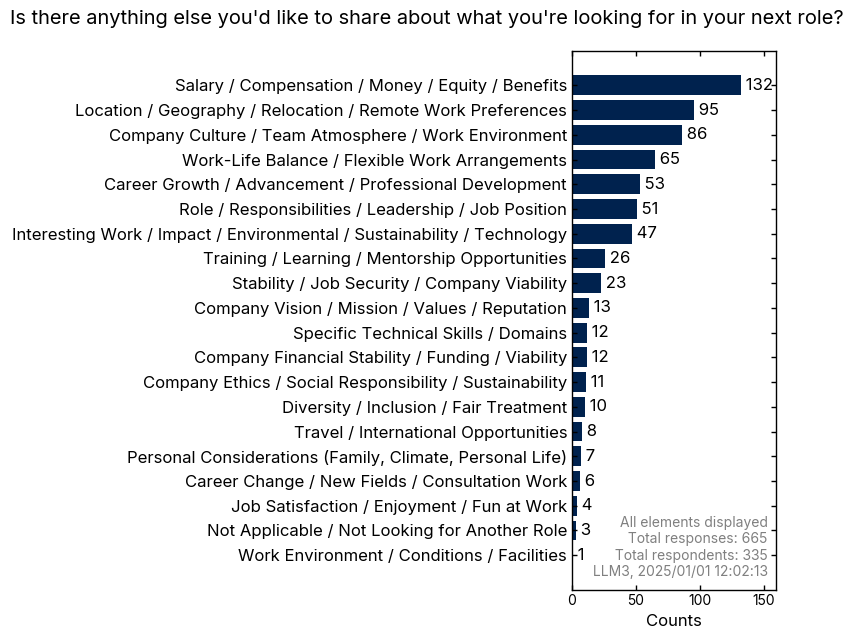

In [12]:
plotter.make_bar_plot_from_dict(counter,
                                title=question['question'],
                                sorted=True,
                                annotation=f'LLM3, {time.strftime("%Y/%m/%d %H:%M:%S")}',
                                num_elements=100,
                                saveas=f'{question['tag']}_{time.strftime("%Y%m%d_%H%M%S")}.png'
)